In [2]:
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_colab():
    !pip install ultralytics
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import stuff
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
import platform
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
import shutil
import cv2
from glob import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device.type}\n")

Using device: cuda



# Data Preparation

In [5]:
# Check the sizes of the images and if any are in RGBA format
if in_colab():
    root = '/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/Project 2/brain-mri'
else:
    root = 'brain-mri'
splits = [dir for dir in os.listdir(root) if dir != '.DS_Store']
categories = [dir for dir in os.listdir(os.path.join(root, splits[0])) if dir != '.DS_Store']
size = 128
img_size = (size, size)
count = 0
non_square = 0
non_RGB_count = 0
for split in splits:
    for category in categories:
        path = os.path.join(root, split, category, 'images')
        for img_name in os.listdir(path):
            if not img_name.endswith('.jpg'):
                continue
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path)
            if img.mode != 'RGB':
                non_RGB_count += 1
            if img.size != img_size:
                #print(f"Image {img_path} has size {img.size}")
                if img.size[0] != img.size[1]:
                    #print(f"Image {img_path} is not square: {img.size}")
                    non_square += 1
                count += 1
print(f"Total images with incorrect size: {count}")
print(f"Total non-square images: {non_square}")
print(f"Total non-RGB images: {non_RGB_count}")

Total images with incorrect size: 5249
Total non-square images: 697
Total non-RGB images: 1002


In [6]:
# Resize images to 128x128 and adjust labels for non-square images
resized_dir = 'resized-data'
shutil.rmtree(resized_dir, ignore_errors=True)
os.makedirs(resized_dir, exist_ok=True)

for split in splits:
    # Make the new directories
    for category in categories:
        resized_img_path = os.path.join(resized_dir, split, category, 'images')
        resized_label_path = os.path.join(resized_dir, split, category, 'labels')
        os.makedirs(resized_img_path, exist_ok=True)
        os.makedirs(resized_label_path, exist_ok=True)

# Resize images and labels
for split in splits:
    for category in categories:
        img_path = os.path.join(root, split, category, 'images')
        label_path = os.path.join(root, split, category, 'labels')
        for img_name in os.listdir(img_path):
            # Skip .DS_Store and whatever else is not a .jpg image
            if not img_name.endswith('.jpg'):
                continue

            # Skip images with no labels
            label_file = img_name.replace('.jpg', '.txt')
            if not os.path.exists(os.path.join(label_path, label_file)):
                continue

            # Skip if there is an image with no labels
            if not os.path.exists(os.path.join(label_path, label_file)):
                continue

            # Skip 128x128 images
            img_full_path = os.path.join(img_path, img_name)
            img = Image.open(img_full_path)

            # Convert RGBA to RGB if necessary
            if img.mode != 'RGB':
                img = img.convert('RGB')

            if img.size == img_size:
                # Copy the image and label as is
                shutil.copy(img_full_path, os.path.join(resized_dir, split, category, 'images', img_name))
                label_full_path = os.path.join(label_path, img_name.replace('.jpg', '.txt'))
                shutil.copy(label_full_path, os.path.join(resized_dir, split, category, 'labels', img_name.replace('.jpg', '.txt')))

            # Resize non-128x128 square images
            elif img.size[0] == img.size[1]:
                # Resize the image and copy to new dir
                img_resized = img.resize(img_size)
                img_resized.save(os.path.join(resized_dir, split, category, 'images', img_name))
                # Copy the label as is
                label_full_path = os.path.join(label_path, img_name.replace('.jpg', '.txt'))
                shutil.copy(label_full_path, os.path.join(resized_dir, split, category, 'labels', img_name.replace('.jpg', '.txt')))

            # Resize non-square images and adjust labels
            else:
                original_width, original_height = img.size
                img_resized = img.resize(img_size)
                img_resized.save(os.path.join(resized_dir, split, category, 'images', img_name))

                # Adjust the label
                label_full_path = os.path.join(label_path, img_name.replace('.jpg', '.txt'))
                with open(label_full_path, 'r') as f:
                    lines = f.readlines()
                adjusted_lines = []
                for line in lines:
                    components = line.strip().split()
                    class_id = components[0]
                    x_center = float(components[1])
                    y_center = float(components[2])
                    width = float(components[3])
                    height = float(components[4])

                    # Adjust x_center and width
                    x_center_adj = x_center * (original_width / size)
                    width_adj = width * (original_width / size)

                    # Adjust y_center and height
                    y_center_adj = y_center * (original_height / size)
                    height_adj = height * (original_height / size)
                    adjusted_line = f"{class_id} {x_center_adj:.6f} {y_center_adj:.6f} {width_adj:.6f} {height_adj:.6f}\n"
                    adjusted_lines.append(adjusted_line)

                # Write the adjusted label
                with open(os.path.join(resized_dir, split, category, 'labels', img_name.replace('.jpg', '.txt')), 'w') as f:
                    f.writelines(adjusted_lines)

# 11 seconds on laptop
# A long time on colab

In [15]:
class BrainMRIDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        global splits, categories # Access global variables for splits and categories

        # Load all splits and categories
        for split in os.listdir(root_dir):
            if split not in splits:
                continue
            split_dir = os.path.join(root_dir, split)
            for category in os.listdir(split_dir):
                if category not in categories:
                    continue
                img_dir = os.path.join(split_dir, category, 'images')
                label_dir = os.path.join(split_dir, category, 'labels')

                for img_name in os.listdir(img_dir):
                    if img_name.endswith('.jpg'):
                        img_path = os.path.join(img_dir, img_name)
                        label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))

                        # Check if label file exists and contains valid bounding box entries
                        if os.path.exists(label_path):
                            with open(label_path, 'r') as f:
                                lines = f.readlines()
                            # Filter for lines that are not empty and have the correct number of components
                            valid_label_lines = [line for line in lines if line.strip() and len(line.strip().split()) == 5]
                            if valid_label_lines: # Only add sample if there are valid bounding boxes
                                self.samples.append({
                                    'img_path': img_path,
                                    'label_path': label_path
                                })
                            # else: # Optional: print a warning if a label file is empty/invalid
                            #     print(f"Warning: Skipping {img_name} due to empty or invalid label file.")
                        # else: # Optional: print a warning if a label file is missing
                        #     print(f"Warning: Skipping {img_name} due to missing label file.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['img_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load labels
        boxes = []
        with open(sample['label_path'], 'r') as f:
            lines = f.readlines()
            for line in lines:
                components = line.strip().split()
                if len(components) == 5: # Ensure the line has enough components (class_id, x, y, w, h)
                    class_id = int(components[0])
                    x_center = float(components[1])
                    y_center = float(components[2])
                    width = float(components[3])
                    height = float(components[4])
                    boxes.append([class_id, x_center, y_center, width, height])

        # At this point, 'boxes' should not be empty because we filtered in __init__
        boxes = torch.tensor(boxes, dtype=torch.float32)

        return image, boxes

In [26]:
# Dataloader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

dataset = BrainMRIDataset(resized_dir, transform=transform)

# Split data
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 4196
Val size: 526
Test size: 524


In [27]:
# Collate function to handle YOLO labels
def collate_fn(batch):
    images = []
    labels = []
    boxes = []

    for image, box in batch:
        images.append(image)
        labels.append(int(box[0][0]))
        boxes.append(box[0][1:5])

    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    boxes = torch.stack(boxes)

    return images, labels, boxes

# Dataloaders with collate
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# CNN

### Model

In [40]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        # Bounding box head
        self.box_regressor = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Sigmoid()  # Squish to [0, 1]
        )

    def forward(self, x):
        x = self.features(x)
        class_pred = self.classifier(x)
        box_pred = self.box_regressor(x)
        return class_pred, box_pred

model = CNN().to(device)

### Parameters

In [41]:
# Define the training parameters
model = CNN(num_classes=4).to(device)
class_criterion = nn.CrossEntropyLoss()
box_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
history = {
    "train_loss": [], "train_class_loss": [], "train_box_loss": [], "train_acc": [],
    "val_loss": [], "val_class_loss": [], "val_box_loss": [], "val_acc": []
}

# Calculate accuracy from logits
def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)  # choose class with highest predicted score
    return (preds == y).float().mean().item()  # fraction of correct predictions

In [42]:
def train(name, filename, weight):
    # Early stopping settings
    patience = 10          # epochs to wait after last improvement
    min_delta = 0.0        # minimum change in val_loss to qualify as improvement
    best_val = 10e20       # track best validation loss
    best_epoch = -1
    patience_ctr = 0
    best_ckpt_path = "best.pt"

    train_start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training
        model.train()
        running_loss, running_class_loss, running_box_loss = 0.0, 0.0, 0.0
        running_correct, total = 0, 0

        for x, class_labels, boxes in train_loader:
            x = x.to(device)
            class_labels = class_labels.to(device)
            boxes = boxes.to(device)

            optimizer.zero_grad(set_to_none=True)
            class_pred, box_pred = model(x)

            # Combined loss
            loss_class = class_criterion(class_pred, class_labels)
            loss_box = box_criterion(box_pred, boxes)
            loss = loss_class + weight * loss_box

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            running_class_loss += loss_class.item() * x.size(0)
            running_box_loss += loss_box.item() * x.size(0)
            running_correct += (class_pred.argmax(1) == class_labels).sum().item()
            total += x.size(0)

        train_loss = running_loss / total
        train_class_loss = running_class_loss / total
        train_box_loss = running_box_loss / total
        train_acc = running_correct / total

        # Validation
        model.eval()
        val_running_loss, val_running_class_loss, val_running_box_loss = 0.0, 0.0, 0.0
        val_running_correct, val_total = 0, 0

        with torch.no_grad():
            for x, class_labels, boxes in val_loader:
                x = x.to(device)
                class_labels = class_labels.to(device)
                boxes = boxes.to(device)

                class_pred, box_pred = model(x)

                loss_class = class_criterion(class_pred, class_labels)
                loss_box = box_criterion(box_pred, boxes)
                loss = loss_class + 5.0 * loss_box

                val_running_loss += loss.item() * x.size(0)
                val_running_class_loss += loss_class.item() * x.size(0)
                val_running_box_loss += loss_box.item() * x.size(0)
                val_running_correct += (class_pred.argmax(1) == class_labels).sum().item()
                val_total += x.size(0)

        val_loss = val_running_loss / val_total
        val_class_loss = val_running_class_loss / val_total
        val_box_loss = val_running_box_loss / val_total
        val_acc = val_running_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_class_loss"].append(train_class_loss)
        history["train_box_loss"].append(train_box_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_class_loss"].append(val_class_loss)
        history["val_box_loss"].append(val_box_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch:02d} | "
            f"train: loss={train_loss:.4f} (cls={train_class_loss:.4f}, box={train_box_loss:.4f}), acc={train_acc:.4f} | "
            f"val: loss={val_loss:.4f} (cls={val_class_loss:.4f}, box={val_box_loss:.4f}), acc={val_acc:.4f} | "
            f"time: {epoch_time:.2f}s")

        # Early stopping check (monitor val_loss)
        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_epoch = epoch
            patience_ctr = 0
            # Save best checkpoint so far
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history,
                "best_val_loss": best_val
            }, best_ckpt_path)
            print(f"  -> New best val_loss {best_val:.4f} at epoch {epoch}. Saved to {best_ckpt_path}.")
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch} "
                    f"(no improvement for {patience} epochs). Best epoch: {best_epoch}.")
                break

    # Total training time
    total_time = time.time() - train_start_time
    print(f"\nTotal training time: {total_time:.2f}s")
    print(f"Best epoch: {best_epoch} | Best val_loss: {best_val:.4f}")

    # Restore best model before final save (in case we stopped after it)
    ckpt = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])

    # Save final artifact (model + history)
    final_path = f"models/{filename}.pth"
    torch.save({
        "model_state": model.state_dict(),
        "history": history,
        "best_epoch": best_epoch,
        "best_val_loss": best_val
    }, final_path)
    print(f"Final model saved to '{final_path}'")

In [43]:
def display_results(path):
    # Load the trained model from file
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    history = checkpoint["history"]

    model.eval()  # set to evaluation mode

    # Prepare x-axis for plots
    epochs_range = range(1, len(history["train_loss"]) + 1)

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Total Loss
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Total Loss")
    ax1.plot(epochs_range, history["train_loss"], label="Train Loss", linestyle="-")
    ax1.plot(epochs_range, history["val_loss"], label="Val Loss", linestyle="--")
    ax1.legend()
    ax1.set_title("Total Loss over Epochs")
    ax1.grid(True, alpha=0.3)

    # Classification and box Loss
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.plot(epochs_range, history["train_class_loss"], label="Train Class Loss", linestyle="-", color="tab:blue")
    ax2.plot(epochs_range, history["val_class_loss"], label="Val Class Loss", linestyle="--", color="tab:blue")
    ax2.plot(epochs_range, history["train_box_loss"], label="Train box Loss", linestyle="-", color="tab:orange")
    ax2.plot(epochs_range, history["val_box_loss"], label="Val box Loss", linestyle="--", color="tab:orange")
    ax2.legend()
    ax2.set_title("Classification & box Loss over Epochs")
    ax2.grid(True, alpha=0.3)

    # Accuracy
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Accuracy")
    ax3.plot(epochs_range, history["train_acc"], label="Train Acc", linestyle="-")
    ax3.plot(epochs_range, history["val_acc"], label="Val Acc", linestyle="--")
    ax3.legend()
    ax3.set_title("Accuracy over Epochs")
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    # Confusion matrix and bounding box evaluation
    # Variables to track accuracy
    test_correct, test_total = 0, 0
    total_iou = 0.0

    # Lists to store predictions and true labels for the confusion matrix
    all_preds, all_trues = [], []

    # Disable gradient computation for faster evaluation
    with torch.no_grad():
        # Loop through the test set in batches
        for images, class_labels, boxes in test_loader:
            # Move inputs to the computation device
            images = images.to(device)
            class_labels = class_labels.to(device)
            boxes = boxes.to(device)

            # Forward pass to get model outputs
            class_pred, box_pred = model(images)

            # Get predicted class indices (highest logit per sample)
            preds = class_pred.argmax(1).cpu().numpy()

            # Store predictions and ground truth labels
            all_preds.append(preds)
            all_trues.append(class_labels.cpu().numpy())

            # Update accuracy counters
            test_correct += (preds == class_labels.cpu().numpy()).sum()
            test_total += class_labels.size(0)

            # Calculate IoU for bounding boxes
            # Convert from (x_center, y_center, w, h) to (x1, y1, x2, y2)
            def xywh_to_xyxy(boxes):
                x_center, y_center, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
                x1 = x_center - w / 2
                y1 = y_center - h / 2
                x2 = x_center + w / 2
                y2 = y_center + h / 2
                return torch.stack([x1, y1, x2, y2], dim=1)

            pred_boxes_xyxy = xywh_to_xyxy(box_pred)
            true_boxes_xyxy = xywh_to_xyxy(boxes)

            # Calculate IoU
            from torchvision.ops import box_iou
            ious = box_iou(pred_boxes_xyxy, true_boxes_xyxy)
            total_iou += ious.diag().sum().item()

    # Compute overall test accuracy
    test_acc = test_correct / test_total
    avg_iou = total_iou / test_total
    print(f"Test Classification Accuracy: {test_acc:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")

    # Flatten predictions and true labels into 1D arrays
    y_true = np.concatenate(all_trues).ravel()
    y_pred = np.concatenate(all_preds).ravel()

    # Detect classes from both true and predicted
    class_labels_unique = np.unique(np.concatenate((y_true, y_pred)))
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    display_names = [class_names[i] if i < len(class_names) else str(i) for i in class_labels_unique]
    print(f"Detected {len(class_labels_unique)} classes: {class_labels_unique}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels_unique)

    # Plot annotated confusion matrix
    plt.figure(figsize=(8, 7))
    sns.heatmap(
        cm,
        annot=True,              # annotate all cells
        fmt="d",                 # integer format
        cbar=True,
        xticklabels=display_names,
        yticklabels=display_names,
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix (Test)\nAccuracy: {test_acc:.4f}, Avg IoU: {avg_iou:.4f}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

#### 5x weight for boxes

In [44]:
train(CNN, "CNN1", 5)

Epoch 01 | train: loss=2.3169 (cls=0.8573, box=0.2919), acc=0.6578 | val: loss=1.2807 (cls=0.5733, box=0.1415), acc=0.7833 | time: 12.29s
  -> New best val_loss 1.2807 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.5864 (cls=0.4304, box=0.2312), acc=0.8384 | val: loss=1.0808 (cls=0.3883, box=0.1385), acc=0.8688 | time: 12.29s
  -> New best val_loss 1.0808 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.4015 (cls=0.2880, box=0.2227), acc=0.8882 | val: loss=0.9417 (cls=0.2822, box=0.1319), acc=0.9030 | time: 12.34s
  -> New best val_loss 0.9417 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=1.2665 (cls=0.1818, box=0.2169), acc=0.9361 | val: loss=0.9915 (cls=0.3641, box=0.1255), acc=0.8783 | time: 12.34s
Epoch 05 | train: loss=1.1817 (cls=0.1128, box=0.2138), acc=0.9652 | val: loss=0.8652 (cls=0.2444, box=0.1242), acc=0.9392 | time: 12.32s
  -> New best val_loss 0.8652 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=1.1225 (cls=0.0633, box=0.2118), acc=0.9790 | v

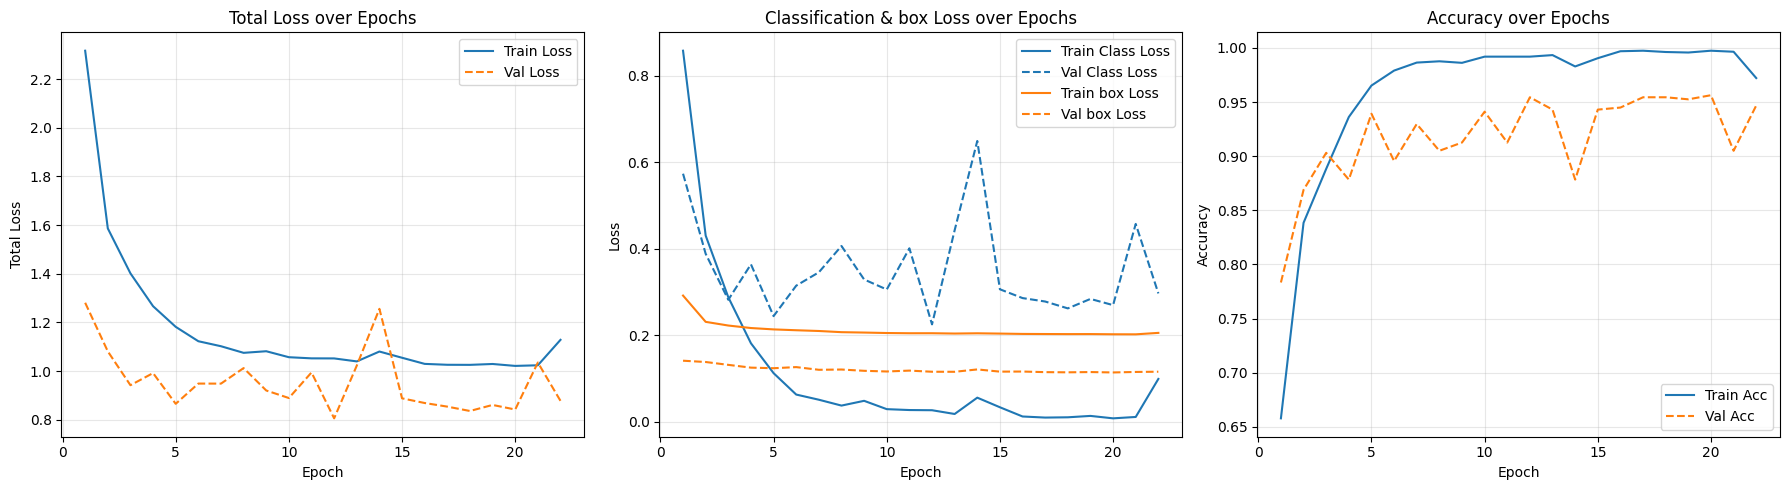

Test Classification Accuracy: 0.9351
Average IoU: 0.3742
Detected 4 classes: [0 1 2 3]


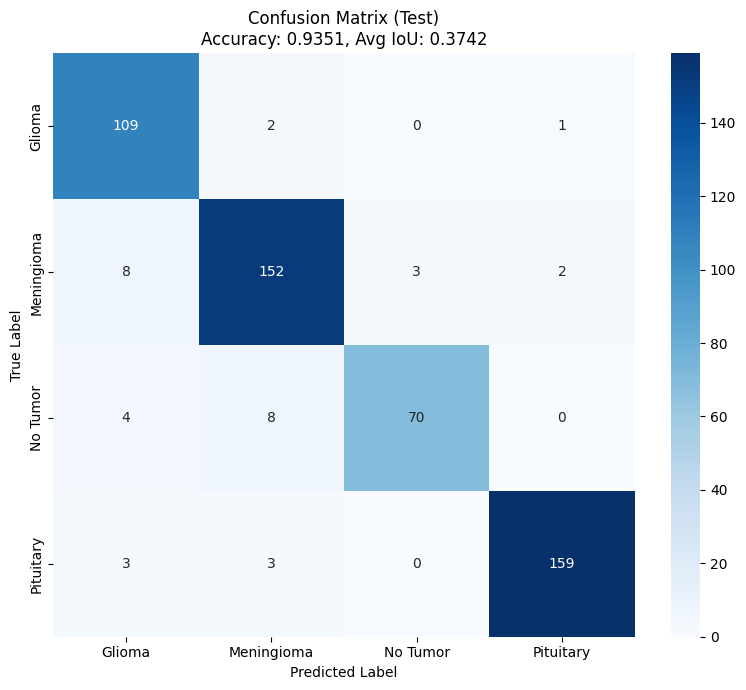

In [45]:
display_results("models/CNN1.pth")

#### 10x weight for boxes

In [ ]:
train(CNN, "CNN2", 10)

In [ ]:
display_results("models/CNN2.pth")